In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import math


def euclidean_distance(matr1, matr2):
    ans = (- 2) * matr1.dot(matr2.T)
    ans += (matr1**2).sum(1, keepdims=True)
    ans += (matr2**2).sum(1)
    return np.sqrt(ans)


def cosine_distance(matr1, matr2):
    ans = -matr1.dot(matr2.T)
    ans[ans == 0] = 1
    b = np.sqrt((matr1**2).sum(1, keepdims=True))
    b[b == 0] = 1
    ans /= b
    b = np.sqrt((matr2**2).sum(1))
    b[b == 0] = 1
    # for 0-vector scalar product = 0 and norma = 0
    # 0/0 eqv 1
    ans /= b
    return np.ones([matr1.shape[0], matr2.shape[0]]) + ans


class KNNClassifier:
    def __init__(self, k=5, strategy='brute', metric='euclidean',
                 weights=False, test_block_size=1):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size

    def fit(self, X, y):
        self.X = X
        self.y = y
        if self.strategy == 'my_own':
            return
        self.neigh = NearestNeighbors(n_neighbors=self.k,
                                      algorithm=self.strategy,
                                      metric=self.metric)
        self.neigh.fit(X, y)

    def find_kneighbors(self, X, return_distance):
        if self.strategy != 'my_own':
            return self.neigh.kneighbors(X, return_distance=return_distance)
        if self.strategy == 'my_own':
            if self.metric == 'cosine':
                dist = cosine_distance(X, self.X)
            else:
                dist = euclidean_distance(X, self.X)
            ind = np.argpartition(dist, np.arange(self.k + 1), axis=1)
            # sort weights (from 0 to k) and take first k
            # sort and argsort take many memory, because sort all elements
            # insteed first k metted, so I use argpartition, take_along_axis
            if return_distance:
                return (np.take_along_axis(dist, ind[:, :(self.k)], axis=1),
                        ind[:, :(self.k)])
            return (ind[:, :(self.k)])

    def predict(self, X):
        (weights, ind) = self.find_kneighbors(X, True)
        if self.weights:
            weights = 1 / (weights + 0.00001)
        else:
            weights = np.ones([X.shape[0], self.k])
        new_weights = np.ndarray([X.shape[0], self.k, 1])
        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                new_weights[i][j][0] = weights[i][j]
        new_matr_y = np.ndarray([ind.shape[0], ind.shape[1], 1])
        for i in range(ind.shape[0]):
            for j in range(ind.shape[1]):
                x = ((i * ind.shape[1] + j) // self.y[ind].shape[1])
                y = ((i * ind.shape[1] + j) % self.y[ind].shape[1])
                new_matr_y[i][j][0] = self.y[ind][x][y]
        arg_sum = (new_matr_y == np.unique(self.y)) * new_weights
        summing = np.sum(arg_sum, axis=1)
        ans_ind = np.argmax(summing, axis=1)
        return np.unique(self.y)[ans_ind]
# such reshape needs to take argmax from each element


def kfold(n, n_folds):
    answer = []
    all_coor = np.arange(n)
    count_short_val = n_folds - n % n_folds
    len_long_val = n // n_folds + 1
    len_short_val = n // n_folds
    count_long_val = (n - len_short_val * count_short_val) // len_long_val
    for i in range(count_long_val):
        arr1 = all_coor[: i * len_long_val]
        arr1 = np.append(arr1, all_coor[(i + 1) * len_long_val:])
        arr2 = all_coor[i * len_long_val: (i + 1) * len_long_val]
        answer.append((arr1, arr2))
    offset = len_long_val * count_long_val
    for i in range(count_short_val):
        arr1 = all_coor[: i * len_short_val + offset]
        arr1 = np.append(arr1, all_coor[(i + 1) * len_short_val + offset:])
        left = i * len_short_val + offset
        right = (i + 1) * len_short_val + offset
        arr2 = all_coor[left: right]
        answer.append((arr1, arr2))
    return answer


def knn_cross_val_score(X, y, k_list, score="accuracy", cv=None,
                        **kwargs):
    if score != 'accuracy':
        return
    answer = {}
    if not cv:
        cv = kfold(X.shape[0], 5)
    knn = KNNClassifier(k=k_list[len(k_list) - 1], **kwargs)
    # I take last k, because if make new KNNClassifier for each k => TL
    # Last k suit for each k
    i_cv = 0
    for train_i, test_i in cv:
        knn.fit(X[train_i], y[train_i])
        len_y = len(y[test_i])
        (dist, ind) = knn.find_kneighbors(X[test_i], True)
        all_names_in_train = y[train_i]
        names = all_names_in_train[ind]
        for k in k_list:
            if i_cv == 0:
                answer[k] = np.ndarray([len(cv)])
            dist_k = dist[:, :k]
            best_names = np.ndarray([names.shape[0]])
            cons_names = names[:, :k]
            j = 0
            for names_j in cons_names:
                if knn.weights:
                    weig = (1 / (dist_k[j] + 0.00001))
                else:
                    weig = np.ones(dist_k[j].shape)
                weights_res = np.bincount(names_j, weights=weig)
                name_of_max = np.argsort(weights_res)[-1]
                best_names[j] = name_of_max
                j += 1
            tmp_ans = 0
            for i in range(len_y):
                if best_names[i] == (y[test_i])[i]:
                    tmp_ans += 1
            (answer[k])[i_cv] = tmp_ans / len_y
        i_cv += 1
    return answer


In [ ]:
rng = np.random.seed(555)

In [ ]:
from sklearn import datasets
data = datasets.fetch_openml("mnist_784")


In [ ]:
import pandas as pd
target = pd.DataFrame(data.target)
data = pd.DataFrame(data.data)

data = data.to_numpy()
target = target.to_numpy()


In [599]:
tmp_target = np.ndarray([target.shape[0]])
for i in range(target.shape[0]):
    tmp_target[i] = (target[i][0])
#target = tmp_target
target = tmp_target.astype('int')

[5 0 4 ... 4 5 6]


In [600]:
train_X = data[:60000, :]
test_X = data[60000:, :]
train_y = target[:60000]
test_y = target[60000:]

In [607]:
import time
t = time.time()

In [602]:
print(time.time() - t)

0.0023479461669921875


In [603]:
import random
np.random.seed(555)

In [612]:
import time
df_time = pd.DataFrame(columns=['algorithm', 'n_pixels', 'time'])

for algorithm in ['kd_tree', 'ball_tree', 'brute', 'my_own']:
    for count in [10, 20, 100]:
        print(count)
        start = time.time()
        knn = KNNClassifier(5, algorithm, 'euclidean', False, 1)
        knn.fit(train_X[:, :count], train_y)
        knn.find_kneighbors(test_X[:, :count], False)
        _time = time.time() - start
        new_line = pd.DataFrame({'algorithm': [algorithm], 'count': [count], 'time': [_time]})
        df_time = df_time.append(new_line, ignore_index=True)
        print(algorithm, count, _time)

10


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


kd_tree 10 3.5174570083618164
20


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


kd_tree 20 5.961963176727295
100


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


kd_tree 100 38.085901975631714
10


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


ball_tree 10 3.0309441089630127
20


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


ball_tree 20 4.951894044876099
100


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


ball_tree 100 35.80056929588318
10


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


brute 10 0.2729499340057373
20


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


brute 20 0.3102536201477051
100


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


brute 100 0.6391868591308594
10


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


my_own 10 27.662996292114258
20


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


my_own 20 23.84430480003357
100
my_own 100 27.83364701271057


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1264230542.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


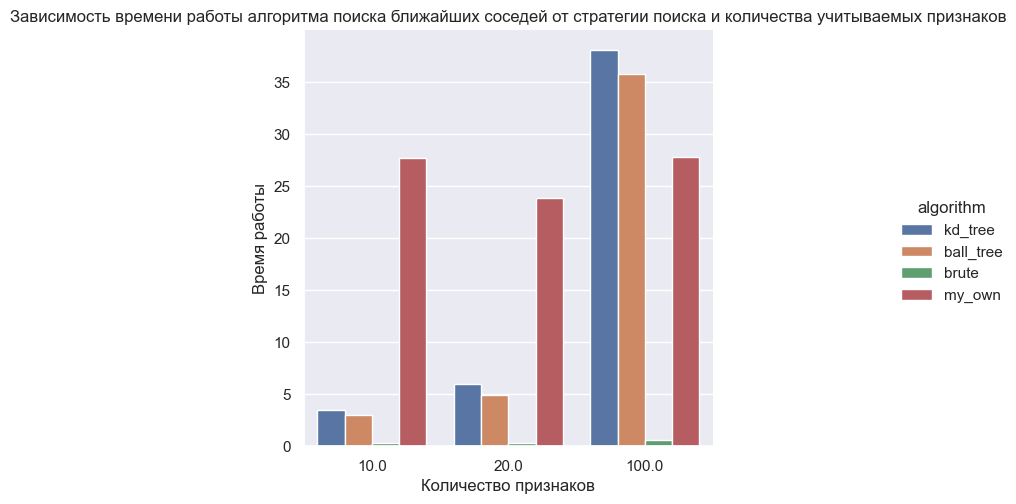

In [618]:
import seaborn as sns
a = sns.catplot(df_time, x="count", y="time", hue="algorithm", kind='bar')
plt.xlabel("Количество признаков")
plt.ylabel("Время работы")
plt.title("Зависимость времени работы алгоритма поиска ближайших соседей от стратегии поиска и количества учитываемых признаков")
a.savefig('picture.pdf')

In [637]:
df_time = pd.DataFrame(columns=['count_neighbors', 'metric_weight', 'accuracy', 'time'])
for k in range(1, 11):
    for metric_and_weight in [('euclidean', False), ('euclidean', True), ('cosine', False), ('cosine', True)]:
        start = time.time()
        knn = knn_cross_val_score(train_X, train_y, [k], 'accuracy', None, **{'metric': metric_and_weight[0], 'weights': metric_and_weight[1]})
        _time = time.time() - start
        new_line = pd.DataFrame({'count_neighbors': [k], 'metric_weight': [metric_and_weight], 'accuracy': [(knn[k][0] + knn[k][1] + knn[k][2]) / 3], 'time': [_time]})
        df_time = df_time.append(new_line, ignore_index=True)
        print('count_neighbors =', k, 'metric_weight =', metric_and_weight, 'accuracy =', (knn[k][0] + knn[k][1] + knn[k][2]) / 3, 'time = ', _time)

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 1 metric_weight = ('euclidean', False) accuracy = 0.9698055555555555 time =  15.795310974121094


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 1 metric_weight = ('euclidean', True) accuracy = 0.9698055555555555 time =  15.572936058044434


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 1 metric_weight = ('cosine', False) accuracy = 0.9736944444444444 time =  125.84330916404724


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 1 metric_weight = ('cosine', True) accuracy = 0.9736944444444444 time =  125.58805704116821


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 2 metric_weight = ('euclidean', False) accuracy = 0.9668611111111112 time =  15.893985033035278


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 2 metric_weight = ('euclidean', True) accuracy = 0.9698055555555555 time =  15.738987922668457


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 2 metric_weight = ('cosine', False) accuracy = 0.9684722222222222 time =  138.58505702018738


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 2 metric_weight = ('cosine', True) accuracy = 0.9736944444444444 time =  136.21350717544556


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 3 metric_weight = ('euclidean', False) accuracy = 0.9707499999999999 time =  14.948267698287964


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 3 metric_weight = ('euclidean', True) accuracy = 0.9712222222222223 time =  15.169017791748047


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 3 metric_weight = ('cosine', False) accuracy = 0.9746944444444444 time =  152.42097210884094


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 3 metric_weight = ('cosine', True) accuracy = 0.97525 time =  150.61738204956055


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 4 metric_weight = ('euclidean', False) accuracy = 0.9698333333333333 time =  15.333603858947754


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 4 metric_weight = ('euclidean', True) accuracy = 0.9718333333333332 time =  15.211618900299072


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 4 metric_weight = ('cosine', False) accuracy = 0.9727222222222222 time =  133.42553877830505


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 4 metric_weight = ('cosine', True) accuracy = 0.9756944444444445 time =  133.61718487739563


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 5 metric_weight = ('euclidean', False) accuracy = 0.96975 time =  15.677695989608765


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 5 metric_weight = ('euclidean', True) accuracy = 0.9705833333333334 time =  15.1077880859375


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 5 metric_weight = ('cosine', False) accuracy = 0.9737777777777777 time =  134.4891152381897


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 5 metric_weight = ('cosine', True) accuracy = 0.9745833333333334 time =  133.20806288719177


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 6 metric_weight = ('euclidean', False) accuracy = 0.9686111111111111 time =  15.283554077148438


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 6 metric_weight = ('euclidean', True) accuracy = 0.9712500000000001 time =  15.484735012054443


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 6 metric_weight = ('cosine', False) accuracy = 0.9721944444444445 time =  132.73715829849243


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 6 metric_weight = ('cosine', True) accuracy = 0.9747222222222223 time =  140.97055625915527


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 7 metric_weight = ('euclidean', False) accuracy = 0.9680277777777778 time =  15.254478216171265


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 7 metric_weight = ('euclidean', True) accuracy = 0.968861111111111 time =  15.491504192352295


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 7 metric_weight = ('cosine', False) accuracy = 0.97175 time =  133.01559782028198


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 7 metric_weight = ('cosine', True) accuracy = 0.9728888888888889 time =  132.90698075294495


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 8 metric_weight = ('euclidean', False) accuracy = 0.9666944444444444 time =  15.558560848236084


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 8 metric_weight = ('euclidean', True) accuracy = 0.9688055555555556 time =  15.586942911148071


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 8 metric_weight = ('cosine', False) accuracy = 0.9702500000000001 time =  132.0696849822998


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 8 metric_weight = ('cosine', True) accuracy = 0.9728888888888889 time =  132.1946358680725


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 9 metric_weight = ('euclidean', False) accuracy = 0.9660555555555556 time =  16.006585121154785


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 9 metric_weight = ('euclidean', True) accuracy = 0.967138888888889 time =  15.584141969680786


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 9 metric_weight = ('cosine', False) accuracy = 0.9701944444444445 time =  133.31822204589844


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 9 metric_weight = ('cosine', True) accuracy = 0.9709444444444445 time =  134.09258103370667


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 10 metric_weight = ('euclidean', False) accuracy = 0.9656388888888889 time =  15.402168035507202


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 10 metric_weight = ('euclidean', True) accuracy = 0.9671944444444445 time =  15.61213207244873


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


count_neighbors = 10 metric_weight = ('cosine', False) accuracy = 0.9688888888888889 time =  134.3515567779541
count_neighbors = 10 metric_weight = ('cosine', True) accuracy = 0.9714166666666667 time =  131.35082983970642


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2907747296.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_time = df_time.append(new_line, ignore_index=True)


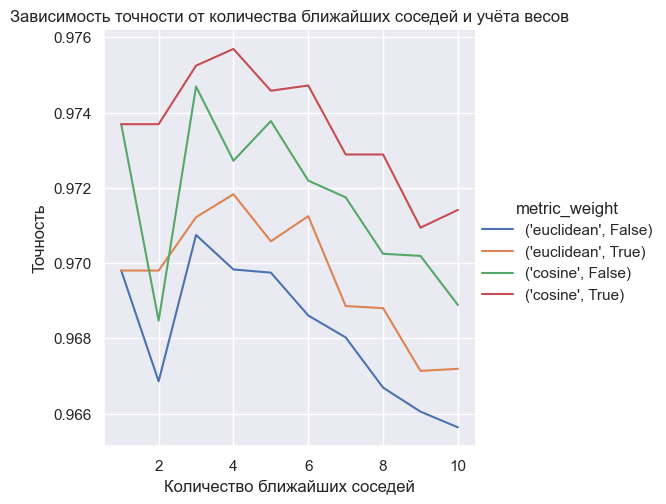

In [642]:
#print(df_time)
a = sns.relplot(data=df_time, x='count_neighbors', y='accuracy', hue='metric_weight', kind='line')
plt.xlabel("Количество ближайших соседей")
plt.ylabel("Точность")
plt.title("Зависимость точности от количества ближайших соседей и учёта весов")
a.savefig('picture2.pdf')

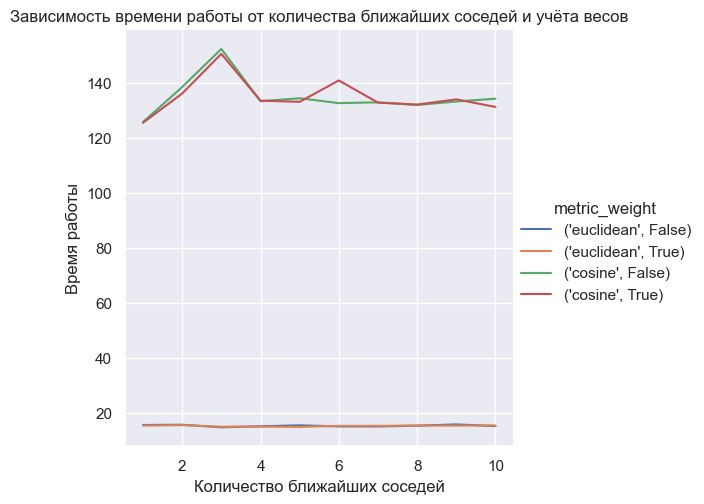

In [643]:
a = sns.relplot(data=df_time, x='count_neighbors', y='time', hue='metric_weight', kind='line')
plt.xlabel("Количество ближайших соседей")
plt.ylabel("Время работы")
plt.title("Зависимость времени работы от количества ближайших соседей и учёта весов")
a.savefig('picture3.pdf')

In [645]:
# task 4
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(train_X, train_y)
pred = knn.predict(test_X)
accur = knn_cross_val_score(train_X, train_y, [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})

In [646]:
print(np.mean(accur[4]))
count = len(test_y)
t = 0
for i in range(count):
    if pred[i] == test_y[i]:
        t += 1
accur = t / count
print(t / count)

0.9754333333333334
0.9752


In [647]:
import sklearn
conf = sklearn.metrics.confusion_matrix(test_y, pred)

In [704]:
def print_conf_matr(conf):
    tmp = pd.DataFrame(columns=["predict", "true", "count"])
    ind = 0
    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            new_line = [j, i, conf[i][j]]
            tmp.loc[ind] = new_line
            ind += 1
    a = sns.heatmap(tmp.pivot(index='true', columns='predict', values='count'), annot=True, fmt=".0f", vmax=60, cmap='BuPu')
    plt.xlabel("Предсказание")
    plt.ylabel("Истинa")
    plt.title("Матрица ошибок")
    plt.savefig('last4.pdf')

In [653]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
import pandas as pd
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import skimage
import scipy
#import cv2 as cv
from sklearn.model_selection import train_test_split

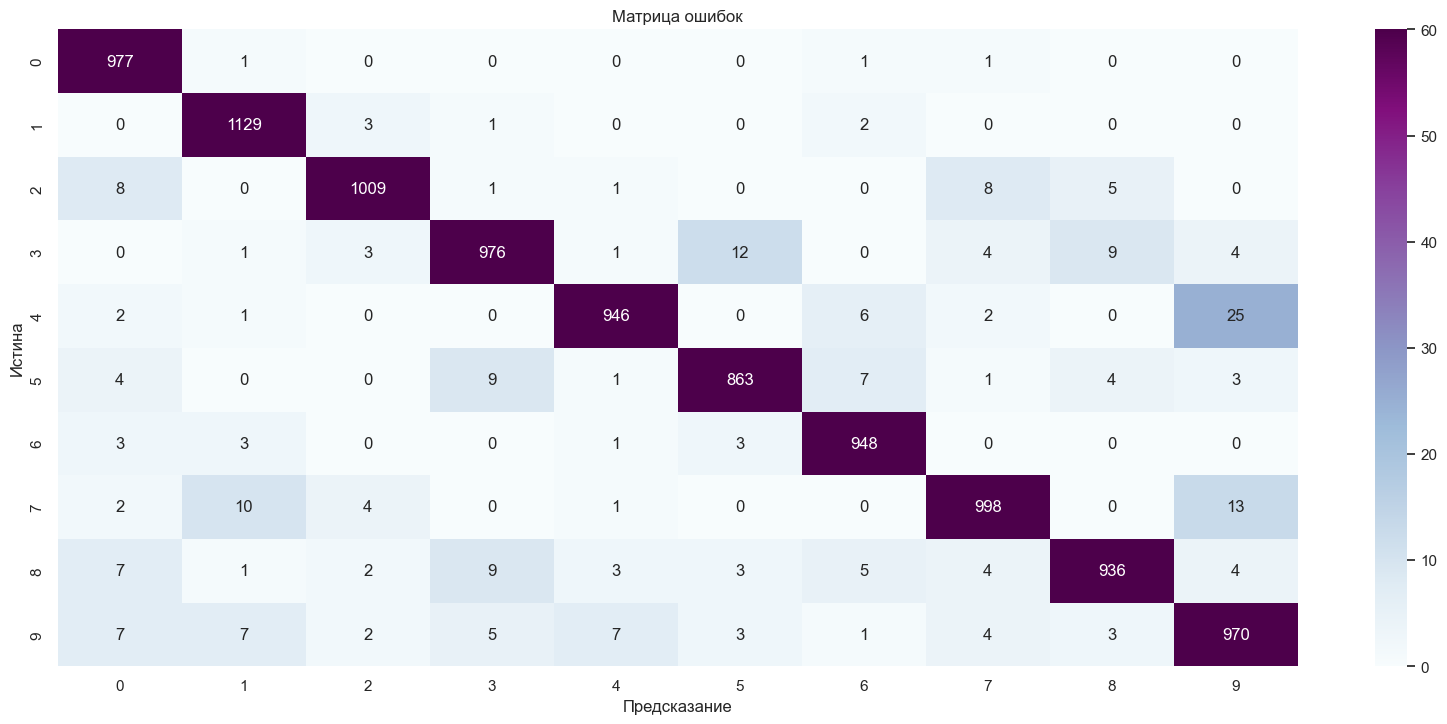

In [654]:
print_conf_matr(conf)

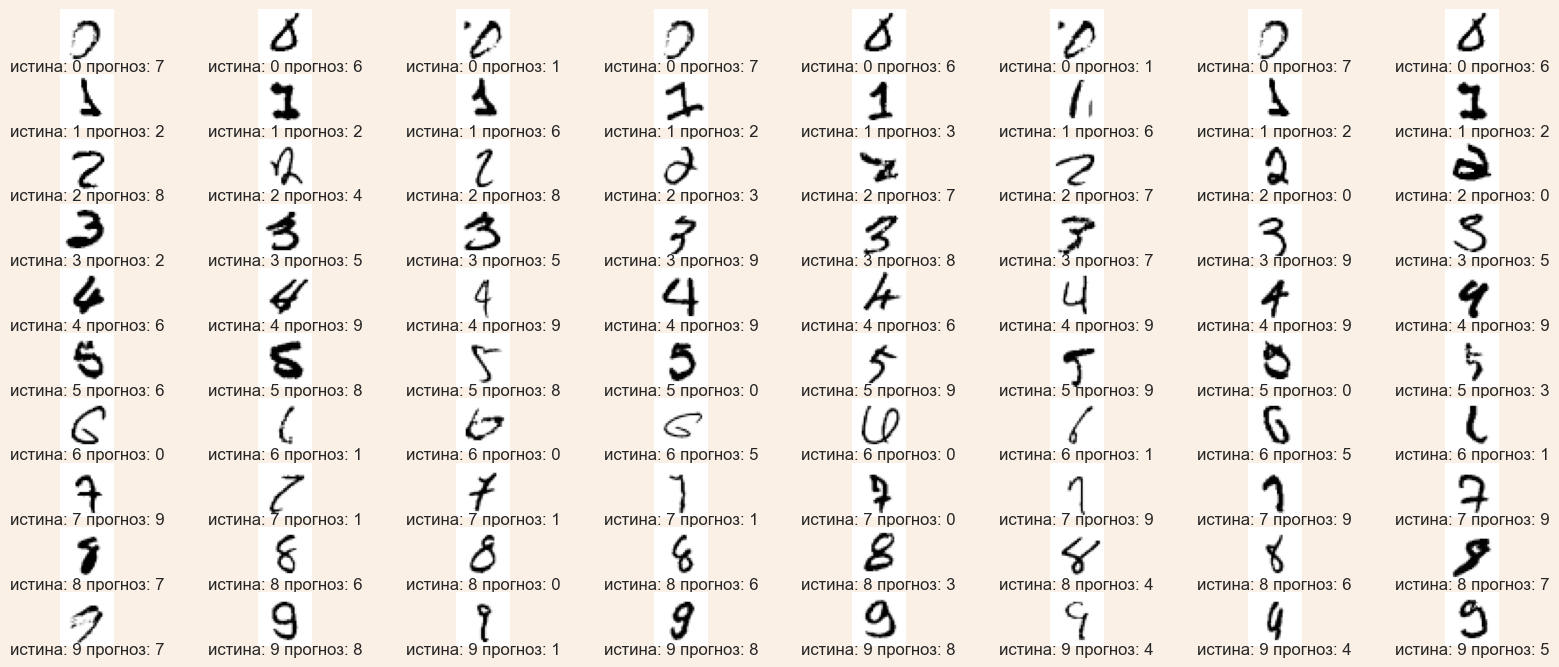

In [655]:
import math
i = j = 0
while j < 80:
  if test_y[i % 10000] != pred[i % 10000] and test_y[i % 10000] == j // 8:
    plt.subplot(10, 8, 1 + j)
    plt.imshow(np.reshape(test_X[i], (int(math.sqrt(784)), int(math.sqrt(784)))), cmap="Greys")
    plt.title(f'истина: {test_y[i]} прогноз: {pred[i]}', y = -0.3)
    plt.axis("off")
    plt.gcf().set_facecolor('linen')
    j += 1
  i += 1
  if i > 10000:
        i = i % 10000
plt.savefig('picture5.pdf')

In [660]:
# task 5

ind = np.random.choice(60000, 20000, replace=False)
aug_train_X = train_X[ind]
aug_train_y = train_y[ind]
info = pd.DataFrame(columns=['angle', 'accuracy'])
accur_before = knn_cross_val_score(aug_train_X, aug_train_y, [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
new_line = pd.DataFrame({'angle': [0], 'accuracy': [np.mean(accur_before[4])]})
info = info.append(new_line, ignore_index=True)
print(np.mean(accur_before[4]))
aug_ind = np.random.choice(20000, 2000, replace=False)
for angle in [5, 10, 15]:
    for k in [-1, 1]:
      rotated_train = np.array([np.resize(skimage.transform.rotate(np.resize(i, (28, 28)), angle * k), 784) for i in aug_train_X[aug_ind]])
      accur_after = knn_cross_val_score(np.concatenate((aug_train_X, rotated_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      new_line = pd.DataFrame({'angle': [angle * k], 'accuracy': [np.mean(accur_after[4])]})
      info = info.append(new_line, ignore_index=True)
      print('angle =', k * angle, 'res = ', np.mean(accur_after[4]))

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


0.9638


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


angle = -5 res =  0.9707727272727273


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


angle = 5 res =  0.9695454545454545


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


angle = -10 res =  0.9679545454545455


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


angle = 10 res =  0.9675909090909091


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


angle = -15 res =  0.9621363636363636
angle = 15 res =  0.9625


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/1645965567.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


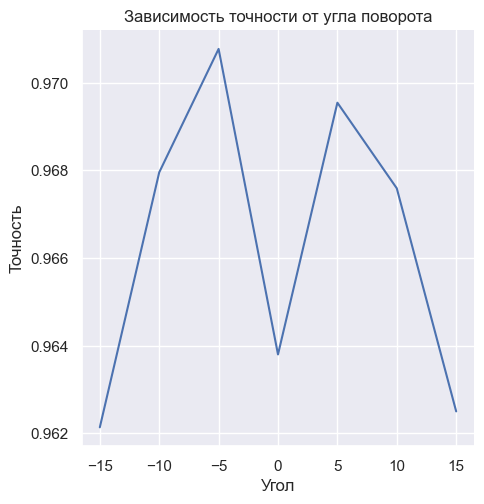

In [661]:
a = sns.relplot(data=info, x='angle', y='accuracy', kind='line')
plt.xlabel("Угол")
plt.ylabel("Точность")
plt.title("Зависимость точности от угла поворота")
a.savefig('angle.pdf')

In [662]:
rotated_train = np.array([np.resize(skimage.transform.rotate(np.resize(i, (28, 28)), 5), (784)) for i in aug_train_X[aug_ind]])
aug_train_X = np.concatenate((aug_train_X, rotated_train), axis=0)
aug_train_y = np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0)
print(aug_train_X.shape)


(22000, 784)


In [663]:
ind = np.random.choice(22000, 20000, replace=False)
print(aug_train_y.shape)

(22000,)


In [664]:
aug_train_X = aug_train_X[ind]
aug_train_y = aug_train_y[ind]
print(aug_train_X.shape)

(20000, 784)


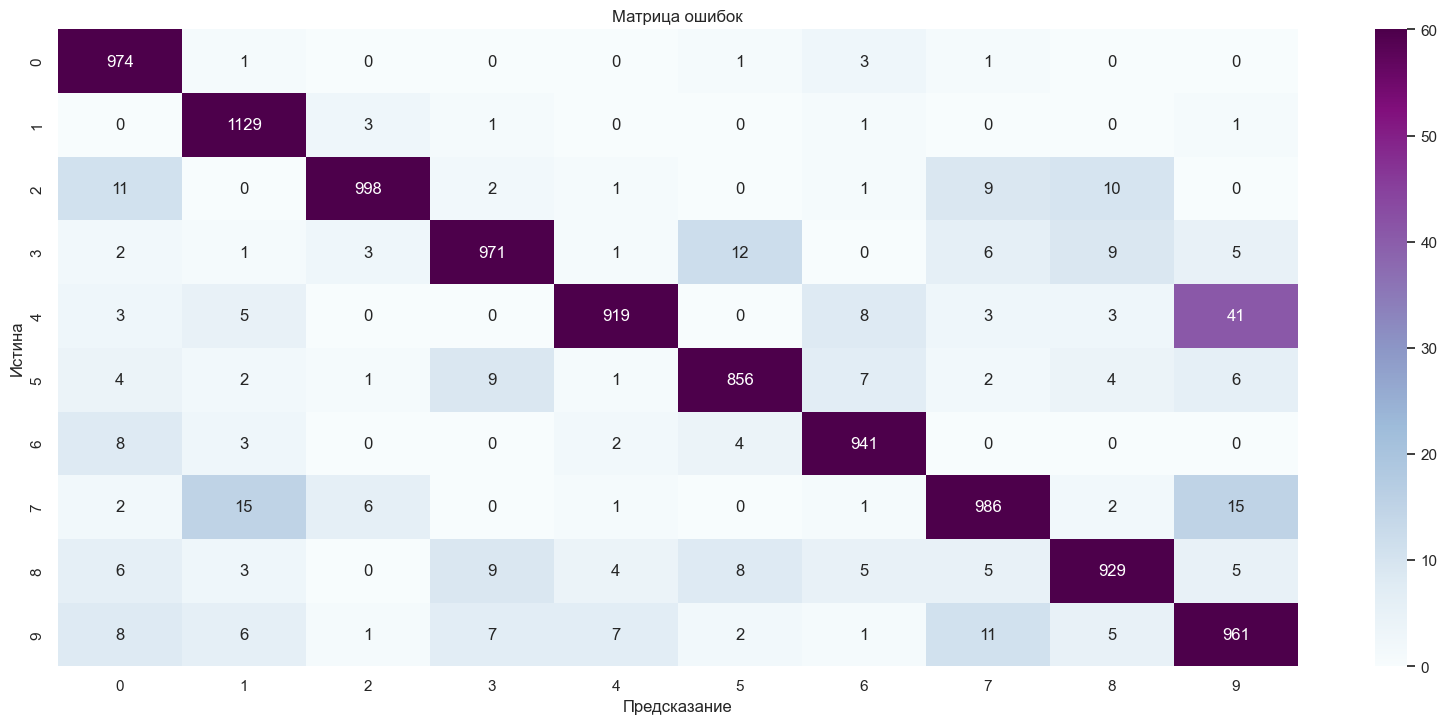

In [666]:
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(aug_train_X, aug_train_y)
pred = knn.predict(test_X)
conf = sklearn.metrics.confusion_matrix(test_y, pred)
print_conf_matr(conf)

In [667]:
count = len(test_y)
t = 0
for i in range(count):
    if pred[i] == test_y[i]:
        t += 1
accur = t / count
print(t / count)

0.9664


In [ ]:
#сдвиг

In [668]:
info = pd.DataFrame(columns=['shift', 'accuracy'])
aug_ind = np.random.choice(20000, 2000, replace=False)
for x_shift in [-3, -2, -1, 0, 1, 2, 3]:
    for y_shift in [-3, -2, -1, 0, 1, 2, 3]:
      shift_train = np.array([np.resize(scipy.ndimage.shift(np.resize(i, (28, 28)), shift=(x_shift , y_shift)), 784) for i in aug_train_X[aug_ind]])
      accur_after = knn_cross_val_score(np.concatenate((aug_train_X, shift_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      new_line = pd.DataFrame({'shift': [(x_shift, y_shift)], 'accuracy': [np.mean(accur_after[4])]})
      info = info.append(new_line, ignore_index=True)
      print('shift =', (x_shift, y_shift), 'res = ', np.mean(accur_after[4]))

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, -3) res =  0.8929545454545454


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, -2) res =  0.9011363636363636


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, -1) res =  0.9118181818181819


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, 0) res =  0.9230454545454545


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, 1) res =  0.9269090909090909


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, 2) res =  0.9179999999999999


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-3, 3) res =  0.9074545454545456


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, -3) res =  0.9019999999999999


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, -2) res =  0.9159090909090908


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, -1) res =  0.9381818181818181


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, 0) res =  0.9521818181818184


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, 1) res =  0.9503181818181818


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, 2) res =  0.9368181818181819


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-2, 3) res =  0.9167727272727273


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, -3) res =  0.9109999999999999


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, -2) res =  0.9338636363636363


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, -1) res =  0.9591818181818181


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, 0) res =  0.9690909090909091


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, 1) res =  0.966090909090909


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, 2) res =  0.9478181818181819


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (-1, 3) res =  0.9261818181818182


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, -3) res =  0.9202272727272728


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, -2) res =  0.9480000000000001


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, -1) res =  0.9682272727272727


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, 0) res =  0.9724999999999999


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, 1) res =  0.9691363636363637


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, 2) res =  0.9485454545454546


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (0, 3) res =  0.9283636363636363


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, -3) res =  0.9260454545454545


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, -2) res =  0.9490909090909092


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, -1) res =  0.9654545454545455


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, 0) res =  0.9698636363636364


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, 1) res =  0.9600454545454544


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, 2) res =  0.9362272727272728


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (1, 3) res =  0.9189545454545455


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, -3) res =  0.9210454545454546


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, -2) res =  0.9383636363636363


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, -1) res =  0.9515454545454546


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, 0) res =  0.9523181818181818


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, 1) res =  0.9376818181818182


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, 2) res =  0.9199090909090909


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (2, 3) res =  0.9065454545454544


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (3, -3) res =  0.9101818181818182


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (3, -2) res =  0.9198636363636364


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (3, -1) res =  0.9300909090909091


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (3, 0) res =  0.9260454545454545


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (3, 1) res =  0.9152727272727275


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


shift = (3, 2) res =  0.9041818181818181
shift = (3, 3) res =  0.8973181818181818


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/2613399048.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


Text(0.5, 1.0, 'Зависимость точности от сдвига')

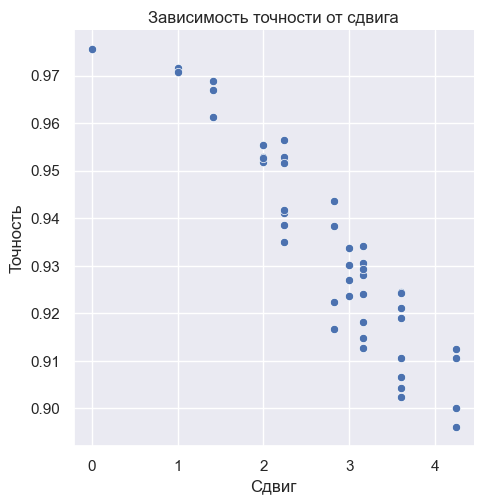

In [461]:
#print(info)
for i in range(49):
    info['shift'][i] = math.sqrt(info['shift'][i][0] ** 2 + info['shift'][i][1] ** 2)
a = sns.relplot(data=info, x='shift', y='accuracy')
plt.xlabel("Сдвиг")
plt.ylabel("Точность")
plt.title("Зависимость точности от сдвига")
a.savefig('shift.pdf')

In [ ]:
#дисперсия

In [669]:
info = pd.DataFrame(columns=['disp', 'accuracy'])
aug_ind = np.random.choice(20000, 2000, replace=False)
for disp in [0, 0.25, 0.5, 0.75, 1, 1.5]:
      disp_train = np.array([np.resize(skimage.filters.gaussian(np.resize(i, (28, 28)), sigma=disp), 784) for i in aug_train_X[aug_ind]])
      accur_after = knn_cross_val_score(np.concatenate((aug_train_X, disp_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      new_line = pd.DataFrame({'disp': [disp], 'accuracy': [np.mean(accur_after[4])]})
      info = info.append(new_line, ignore_index=True)
      print('disp =', disp, 'res = ', np.mean(accur_after[4]))

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/255419648.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


disp = 0 res =  0.9726363636363636


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/255419648.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


disp = 0.25 res =  0.9726363636363636


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/255419648.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


disp = 0.5 res =  0.9732272727272727


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/255419648.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


disp = 0.75 res =  0.9725909090909092


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/255419648.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


disp = 1 res =  0.9717272727272727
disp = 1.5 res =  0.9658181818181818


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/255419648.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


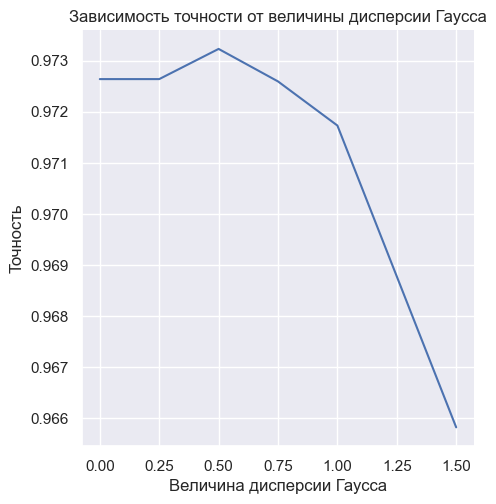

In [670]:
a = sns.relplot(data=info, x='disp', y='accuracy', kind='line')
plt.xlabel("Величина дисперсии Гаусса")
plt.ylabel("Точность")
plt.title("Зависимость точности от величины дисперсии Гаусса")
a.savefig('disp.pdf')

In [671]:
blurry_rotated_train = np.array([np.resize(skimage.filters.gaussian(np.resize(i, (28, 28)), sigma=0.5), 784) for i in aug_train_X[aug_ind]])
aug_train_X = np.concatenate((aug_train_X, blurry_rotated_train), axis=0)
aug_train_y = np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0)
print(aug_train_X.shape)

(22000, 784)


In [672]:
ind = np.random.choice(22000, 20000, replace=False)
aug_train_X = aug_train_X[ind]
aug_train_y = aug_train_y[ind]
print(aug_train_X.shape)

(20000, 784)


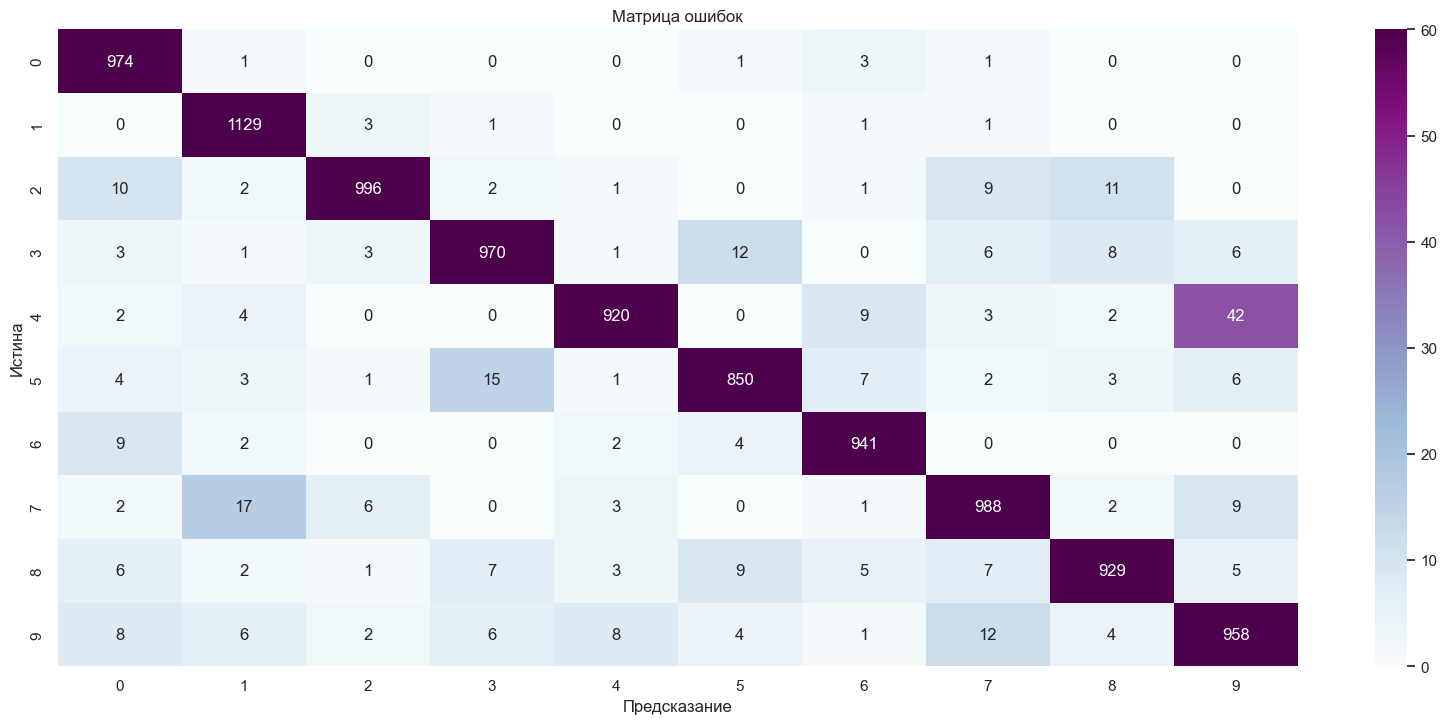

In [674]:
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(aug_train_X, aug_train_y)
pred = knn.predict(test_X)
conf = sklearn.metrics.confusion_matrix(test_y, pred)
print_conf_matr(conf)

In [675]:
count = len(test_y)
t = 0
for i in range(count):
    if pred[i] == test_y[i]:
        t += 1
accur = t / count
print(t / count)

0.9655


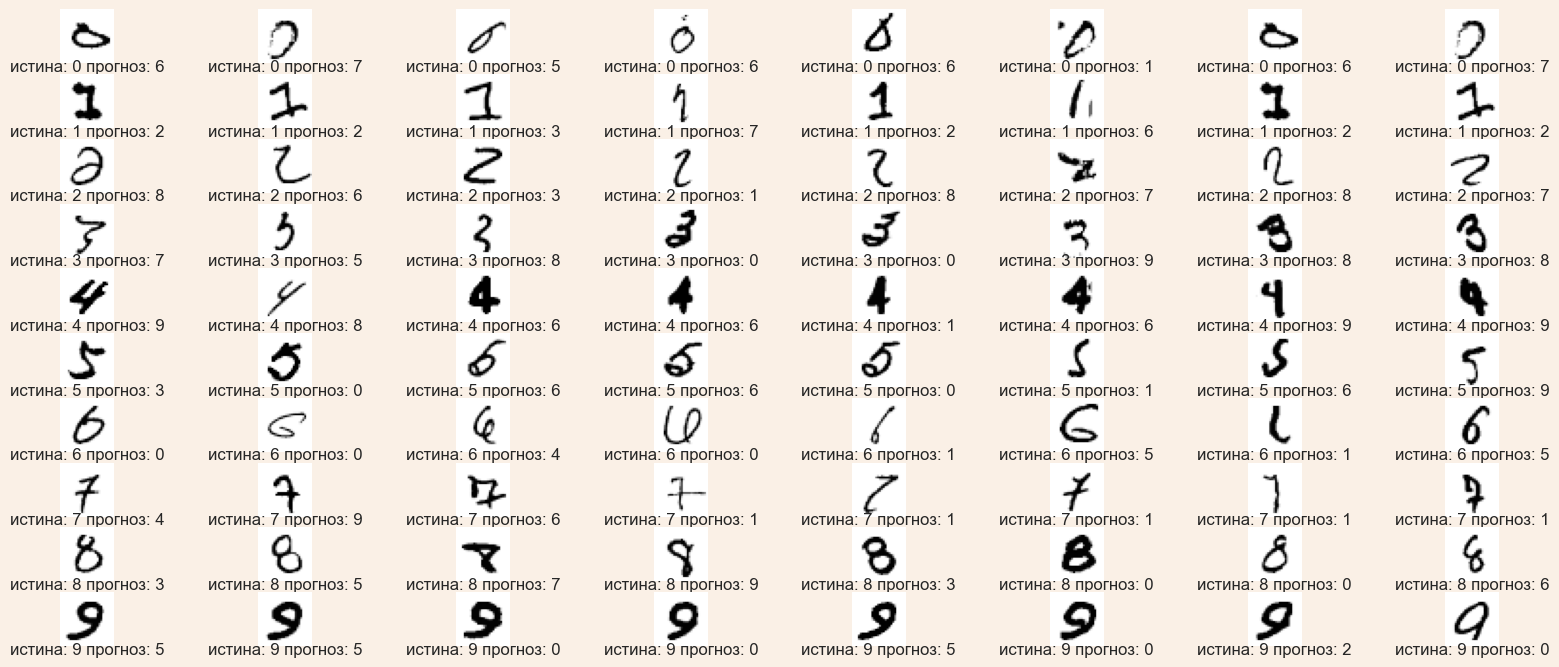

In [676]:
import math
i = j = 0
while j < 80:
  if test_y[i % 10000] != pred[i % 10000] and test_y[i % 10000] == j // 8:
    plt.subplot(10, 8, 1 + j)
    plt.imshow(np.reshape(test_X[i], (int(math.sqrt(784)), int(math.sqrt(784)))), cmap="Greys")
    plt.title(f'истина: {test_y[i]} прогноз: {pred[i]}', y = -0.3)
    plt.axis("off")
    plt.gcf().set_facecolor('linen')
    j += 1
  i += 1
  if i > 10000:
        i = i % 10000

In [677]:
# эрозия

In [678]:
import cv2 as cv
info = pd.DataFrame(columns=['morphological', 'accuracy'])
accur_before = knn_cross_val_score(aug_train_X, aug_train_y, [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
new_line = pd.DataFrame({'morphological': ['nothing'], 'accuracy': [np.mean(accur_before[4])]})
info = info.append(new_line, ignore_index=True)
print(np.mean(accur_before[4]))
kernel = np.ones((2,2), np.uint8)

aug_ind = np.random.choice(20000, 2000, replace=False)
for name in ['erosion', 'dilation', 'opening', 'closing']:
      if name == 'erosion':
          erosion_train = np.array([np.resize(cv.erode(np.resize(i, (28, 28)), kernel, iterations=1), 784) for i in aug_train_X[aug_ind]])
          accur_after = knn_cross_val_score(np.concatenate((aug_train_X, erosion_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      if name == 'dilation':
          dilation_train = np.array([np.resize(cv.dilate(np.resize(i, (28, 28)), kernel, iterations=1), 784) for i in aug_train_X[aug_ind]])
          accur_after = knn_cross_val_score(np.concatenate((aug_train_X, dilation_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      if name == 'opening':
          opening_train = np.array([np.resize(cv.morphologyEx(np.resize(i, (28, 28)), cv.MORPH_OPEN, kernel), 784) for i in aug_train_X[aug_ind]])
          accur_after = knn_cross_val_score(np.concatenate((aug_train_X, opening_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      if name == 'closing':
          closing_train = np.array([np.resize(cv.morphologyEx(np.resize(i, (28, 28)), cv.MORPH_CLOSE, kernel), 784) for i in aug_train_X[aug_ind]])
          accur_after = knn_cross_val_score(np.concatenate((aug_train_X, closing_train), axis=0),
                                       np.concatenate((aug_train_y, aug_train_y[aug_ind]), axis=0), [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
      new_line = pd.DataFrame({'morphological': [name], 'accuracy': [np.mean(accur_after[4])]})
      info = info.append(new_line, ignore_index=True)
      print('morphological =', name, 'res = ', np.mean(accur_after[4]))

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/883737984.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


0.97075


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/883737984.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


morphological = erosion res =  0.9714090909090908


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/883737984.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


morphological = dilation res =  0.9717727272727272


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/883737984.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


morphological = opening res =  0.9594545454545456
morphological = closing res =  0.9597727272727272


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_41534/883737984.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(new_line, ignore_index=True)


In [679]:
print(info)

  morphological  accuracy
0       nothing  0.970750
1       erosion  0.971409
2      dilation  0.971773
3       opening  0.959455
4       closing  0.959773


In [680]:
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(train_X, train_y)
pred = knn.predict(test_X)
accur = knn_cross_val_score(train_X, train_y, [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
print(np.mean(accur[4]))
count = len(test_y)
t = 0
for i in range(count):
    if pred[i] == test_y[i]:
        t += 1
accur = t / count
print(t / count)

0.9754333333333334
0.9752


In [681]:
aug_train_X = train_X
aug_train_y = train_y
ind = np.random.choice(60000, 2000, replace=False)
rotated_train = np.array([np.resize(skimage.transform.rotate(np.resize(i, (28, 28)), 5), 784) for i in aug_train_X[ind]])
aug_train_X = np.concatenate((aug_train_X, rotated_train), axis=0)
aug_train_y = np.concatenate((aug_train_y, aug_train_y[ind]), axis=0)
ind = np.random.choice(62000, 2000, replace=False)

In [682]:
blurry_rotated_train = np.array([np.resize(skimage.filters.gaussian(np.resize(i, (28, 28)), sigma=0.5), 784) for i in aug_train_X[ind]])
aug_train_X = np.concatenate((aug_train_X, blurry_rotated_train), axis=0)
aug_train_y = np.concatenate((aug_train_y, aug_train_y[ind]), axis=0)

In [683]:
ind = np.random.choice(64000, 2000, replace=False)
dilation_blurry_rotated_train = np.array([np.resize(cv.dilate(np.resize(i, (28, 28)), kernel, iterations=1), 784) for i in aug_train_X[ind]])
aug_train_X = np.concatenate((aug_train_X, dilation_blurry_rotated_train), axis=0)
aug_train_y = np.concatenate((aug_train_y, aug_train_y[ind]), axis=0)

In [684]:
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(aug_train_X, aug_train_y)
pred = knn.predict(test_X)
accur = knn_cross_val_score(aug_train_X, aug_train_y, [4], 'accuracy', None, **{'metric': 'cosine', 'weights': True})
print(np.mean(accur[4]))
count = len(test_y)
t = 0
for i in range(count):
    if pred[i] == test_y[i]:
        t += 1
accur = t / count
print(t / count)

0.9778787878787879
0.9757


In [685]:
# task 6

In [686]:
pred = []
for i in range(10000):
    pred.append([])
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(train_X, train_y)
i = 0
for angle in [5, 10, 15]:
    for k in [-1, 1]:
      rotated_test = np.array([np.resize(skimage.transform.rotate(np.resize(i, (28, 28)), angle * k), (784)) for i in test_X])
      pred_i = knn.predict(rotated_test)
      for i in range(10000):
        pred[i].append(pred_i[i])
      i += 1


In [692]:
one_pred = []
for i in range(10000):
    nums = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    for j in range(10):
        nums[j] = pred[i].count(j)
    one_pred.append(np.argmax(nums))
one_pred = np.array(one_pred)

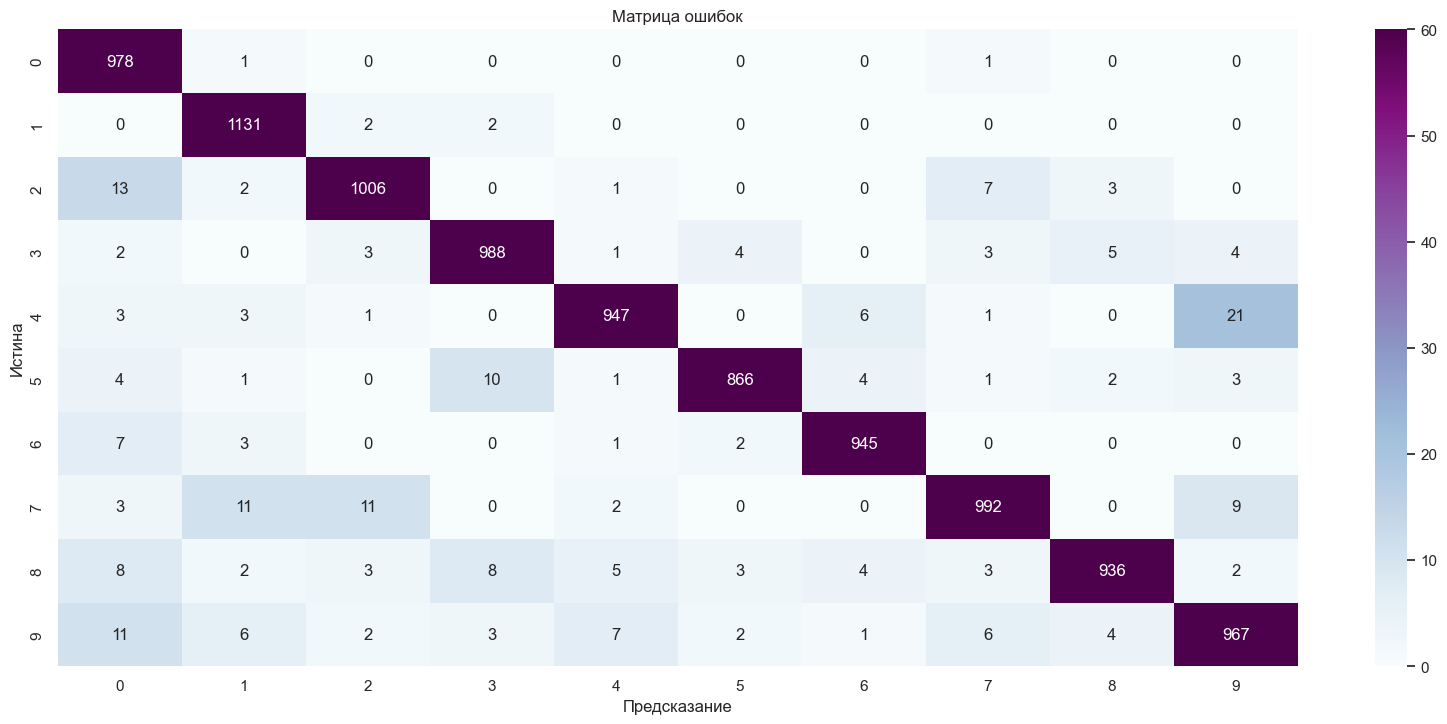

In [694]:
conf = sklearn.metrics.confusion_matrix(test_y, one_pred)
print_conf_matr(conf)

In [695]:
count_right = 0
for i in range(10000):
    if pred[i].count(test_y[i]) > 3:
        count_right += 1
print(count_right / 10000)

0.9666


In [698]:
pred = []
for i in range(10000):
    pred.append([])
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(train_X, train_y)
i = 0
for x_shift in [-3, -2, -1, 0, 1, 2, 3]:
    for y_shift in [-3, -2, -1, 0, 1, 2, 3]:
      print((x_shift , y_shift))
      shifted_test = np.array([np.resize(scipy.ndimage.shift(np.resize(i, (28, 28)), shift=(x_shift , y_shift)), 784) for i in test_X])
      pred_i = knn.predict(shifted_test)
      for i in range(10000):
        pred[i].append(pred_i[i])
      i += 1
count_right = 0
for i in range(10000):
    if pred[i].count(test_y[i]) > 7:
        count_right += 1
print(count_right / 10000)

(-3, -3)
(-3, -2)
(-3, -1)
(-3, 0)
(-3, 1)
(-3, 2)
(-3, 3)
(-2, -3)
(-2, -2)
(-2, -1)
(-2, 0)
(-2, 1)
(-2, 2)
(-2, 3)
(-1, -3)
(-1, -2)
(-1, -1)
(-1, 0)
(-1, 1)
(-1, 2)
(-1, 3)
(0, -3)
(0, -2)
(0, -1)
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, -3)
(1, -2)
(1, -1)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, -3)
(2, -2)
(2, -1)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, -3)
(3, -2)
(3, -1)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
0.9959


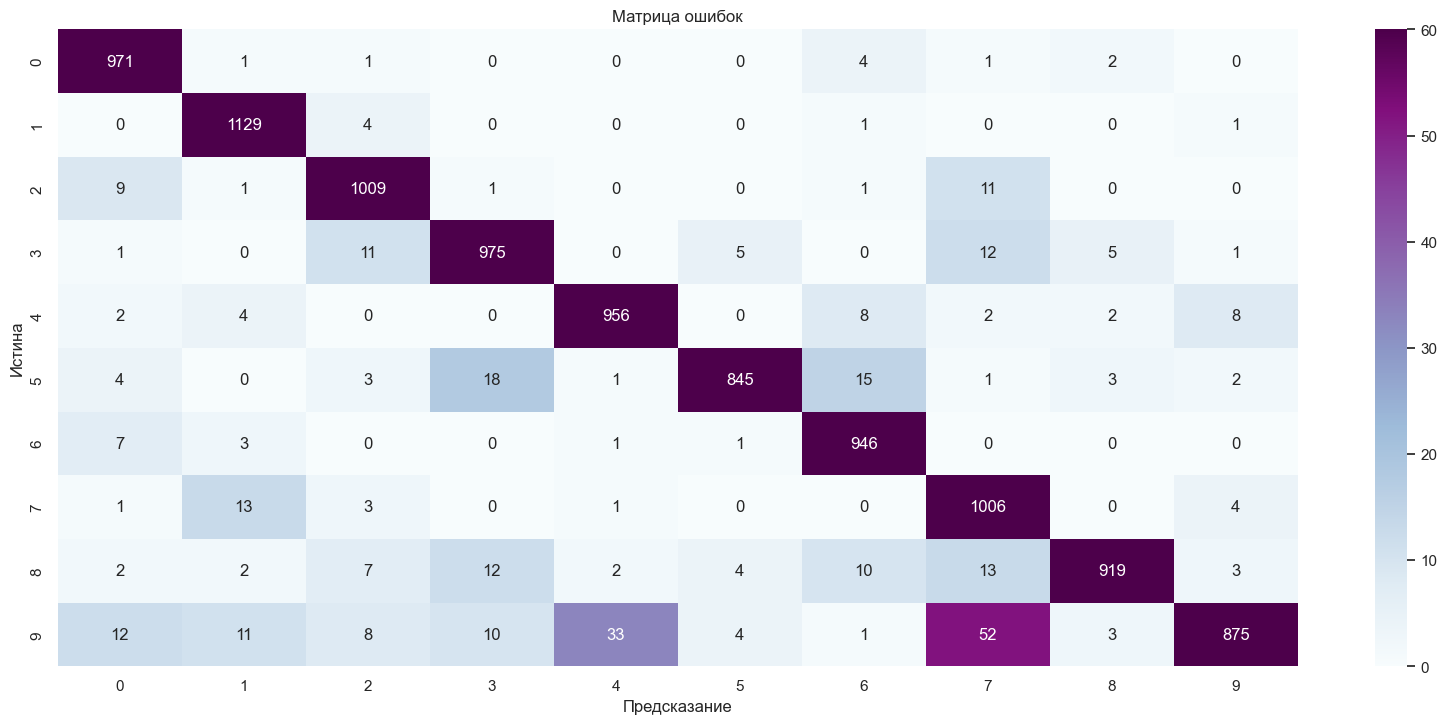

In [700]:
one_pred = []
for i in range(10000):
    nums = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    for j in range(10):
        nums[j] = pred[i].count(j)
    one_pred.append(np.argmax(nums))
one_pred = np.array(one_pred)
conf = sklearn.metrics.confusion_matrix(test_y, one_pred)
print_conf_matr(conf)
#last2

In [702]:
pred = []
for i in range(10000):
    pred.append([])
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(train_X, train_y)
i = 0
for disp in [0, 0.25, 0.5, 0.75, 1, 1.5]:
    print(disp)
    gauss_test = np.array([np.resize(skimage.filters.gaussian(np.resize(i, (28, 28)), sigma=disp), 784) for i in test_X])
    pred_i = knn.predict(gauss_test)
    for i in range(10000):
        pred[i].append(pred_i[i])
    i += 1
count_right = 0
for i in range(10000):
    if pred[i].count(test_y[i]) > 3:
        count_right += 1
print(count_right / 10000)

0
0.25
0.5
0.75
1
1.5
0.9684


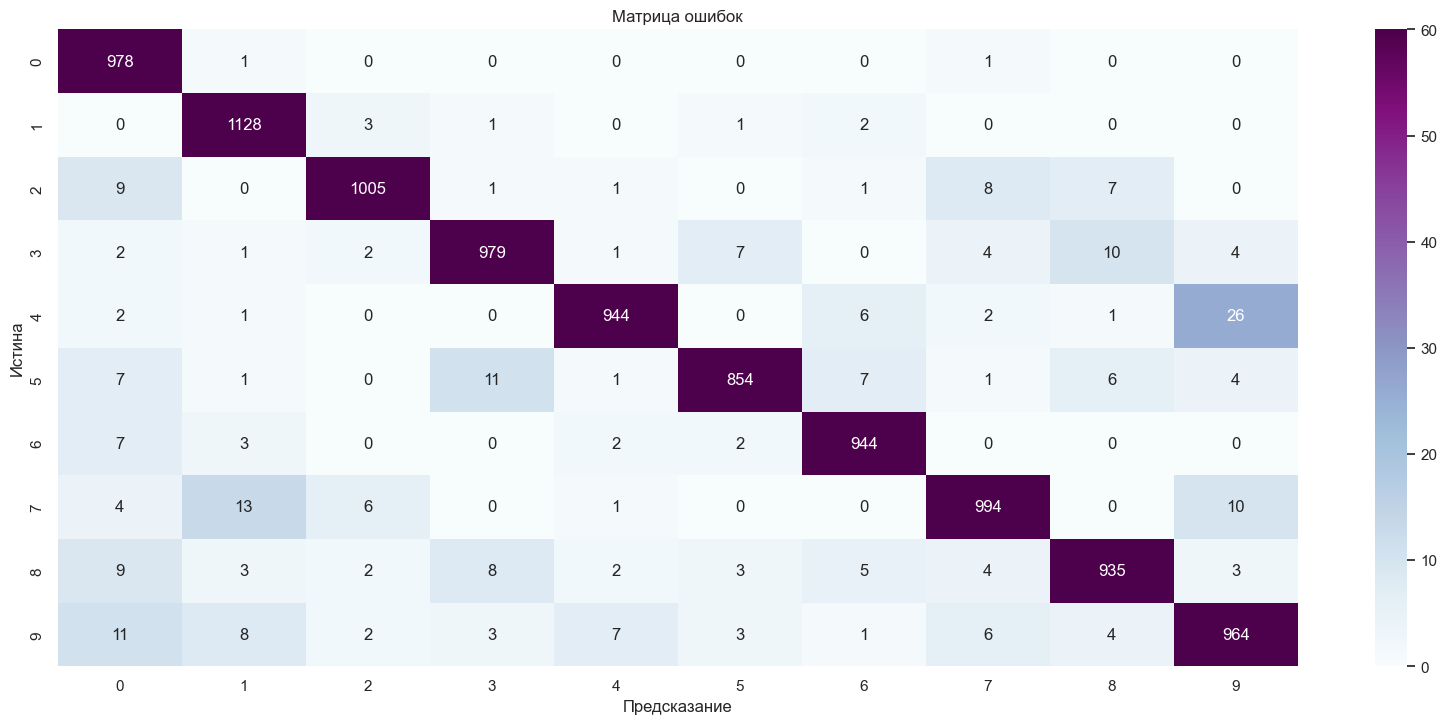

In [703]:
one_pred = []
for i in range(10000):
    nums = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    for j in range(10):
        nums[j] = pred[i].count(j)
    one_pred.append(np.argmax(nums))
one_pred = np.array(one_pred)
conf = sklearn.metrics.confusion_matrix(test_y, one_pred)
print_conf_matr(conf)
#last3

In [705]:
pred = []
for i in range(10000):
    pred.append([])
knn = KNNClassifier(4, 'brute', 'cosine', True, 5)
knn.fit(train_X, train_y)
i = 0
for name in ['erosion', 'dilation', 'opening', 'closing']:
      if name == 'erosion':
          morf_test = np.array([np.resize(cv.erode(np.resize(i, (28, 28)), kernel, iterations=1), 784) for i in test_X])
      if name == 'dilation':
          morf_test = np.array([np.resize(cv.dilate(np.resize(i, (28, 28)), kernel, iterations=1), 784) for i in test_X])
      if name == 'opening':
          morf_test = np.array([np.resize(cv.morphologyEx(np.resize(i, (28, 28)), cv.MORPH_OPEN, kernel), 784) for i in test_X])
      if name == 'closing':
          morf_test = np.array([np.resize(cv.morphologyEx(np.resize(i, (28, 28)), cv.MORPH_CLOSE, kernel), 784) for i in test_X])
      pred_i = knn.predict(morf_test)
      for i in range(10000):
        pred[i].append(pred_i[i])
      i += 1
count_right = 0
for i in range(10000):
    if pred[i].count(test_y[i]) > 2:
        count_right += 1
print(count_right / 10000)

0.8806


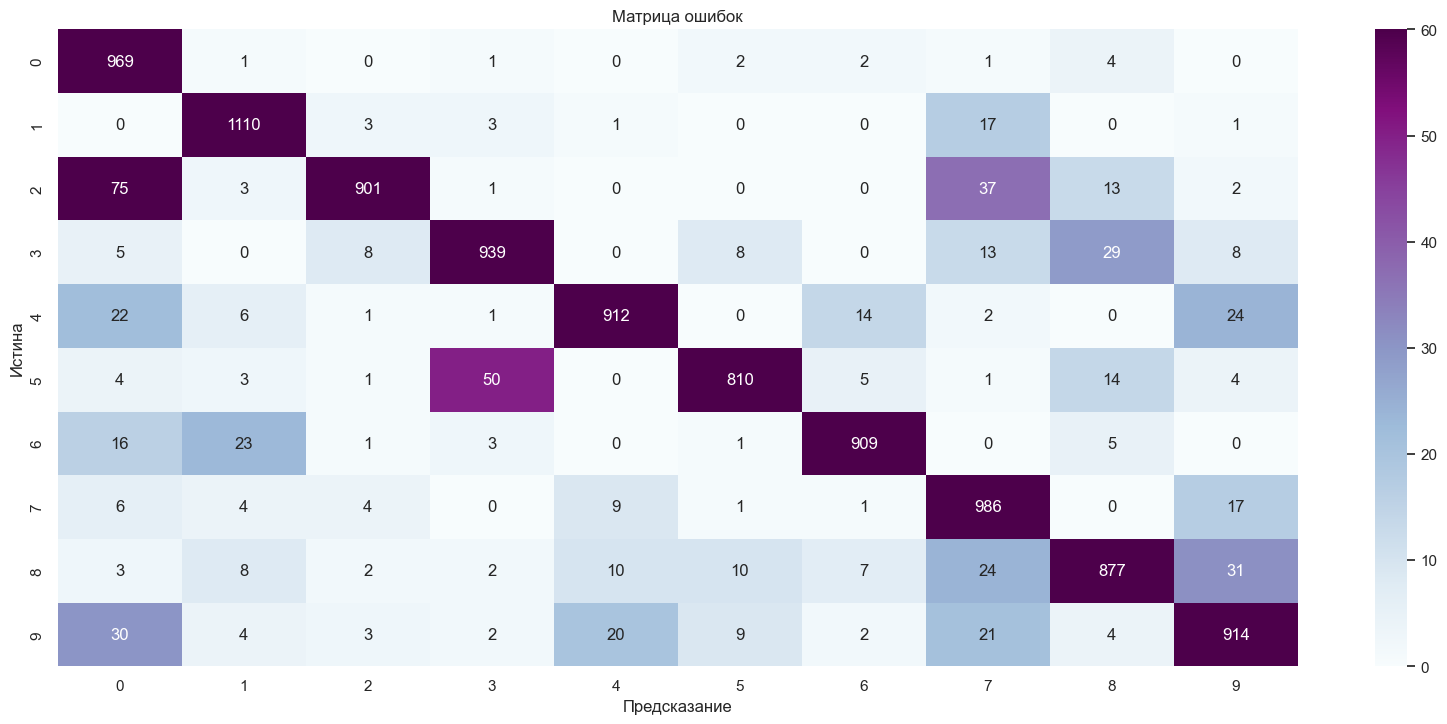

In [706]:
one_pred = []
for i in range(10000):
    nums = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    for j in range(10):
        nums[j] = pred[i].count(j)
    one_pred.append(np.argmax(nums))
one_pred = np.array(one_pred)
conf = sklearn.metrics.confusion_matrix(test_y, one_pred)
print_conf_matr(conf)
#last4